In [1]:
#importing packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import ipywidgets as widgets
import random as rnd
from sklearn import neighbors, tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import norm
from ipywidgets import interact_manual
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

# Step 1: Data Processing -
<b>The dataset itself is comprised of synthetic information about transactions including festures about the transaction such as merchant and locaiton information, as well as information about the card holder. As processing begins, the simplest things to remove like null values and duplicates are checked.</b>

In [2]:
#data file
df = pd.read_csv('fraudTrain_subset.csv')
print(df.shape)

(407446, 22)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407446 entries, 0 to 407445
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  407446 non-null  object 
 1   cc_num                 407446 non-null  float64
 2   merchant               407446 non-null  object 
 3   category               407446 non-null  object 
 4   amt                    407446 non-null  float64
 5   first                  407446 non-null  object 
 6   last                   407446 non-null  object 
 7   gender                 407446 non-null  object 
 8   street                 407446 non-null  object 
 9   city                   407446 non-null  object 
 10  state                  407446 non-null  object 
 11  zip                    407446 non-null  int64  
 12  lat                    407446 non-null  float64
 13  long                   407446 non-null  float64
 14  city_pop               407446 non-nu

In [4]:
duplicates = df.duplicated().sum()
print(duplicates)

0


In [5]:
nulls = df.isnull().sum()
print(nulls)

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


<b>There were no duplicates or null values that could be removed. Next I wanted to look at the data for potential candidates to remove based on size of our two main groups (fraud vs. real) to get the file size down to a manageable value.</b>

In [6]:
print(df['is_fraud'].value_counts())

is_fraud
0    399999
1      7447
Name: count, dtype: int64


<b>Since we will be using a random forest for our model, the difference in size of the number of true and fraudulent transactions could be a concern and an aspect to revisit if our model is biased. At the moment we will see how the model does.</b>

<b>We are going to split our data into a more even dataset by taking the number of fraud instances above and randomly pulling a number of non-fraud cases. This may lead to issues that need to be revisited due to data loss but that can always be revisited. We are also doing this to decrease the training file size to meet the requirements of the project size limits. The code for this will be included here, but the file that will be used throughout the project from the beginning is going to be the one created in this code section. The original file included roughly 1.3 million lines of transaction data.</b>

<b>We are also going to split off a random batch of 10,000 transactions to simulate having "real life" data the bank will submit later.</b> 

In [7]:
df = df.sample(frac=1, random_state=42)
bank_df = df[:9999]
df = df[10000:]

###Split data into subsets
#fraud = df.loc[df['is_fraud'] == 1]
#non_fraud = df.loc[df['is_fraud'] == 0][:399999]
#new_df = pd.concat([fraud, non_fraud], ignore_index=True)

#save subsets and bank data to csv
#bank_df.to_csv(r'C:\Users\gtimlaro\Documents\Capstone Project\bank_data.csv', index=False)
#df.to_csv(r'C:\Users\gtimlaro\Documents\Capstone Project\fraudTrain_subset.csv', index=False)

#new_df.sample(frac=1, random_state=42)
#new_df.info()
#print(new_df['is_fraud'].value_counts())

#df = new_df

<b>Next we need to be able to visualize all of this information which means we need to convert the data types into something we can use with our libraries. This is going to require transforming data types and converting our datetime information to actual datetime format.</b>

<b>For our datetime specifically, we are going to separate the transaction datetime into year, month, and day information and drop the datetime since every datetime should be a unique value and not contribute to training our model very well.</b>

In [8]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df['unix_time'] = pd.to_datetime(df['unix_time'], unit='s')

df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day

df = df.drop(columns = ['trans_date_trans_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397446 entries, 161751 to 121958
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cc_num      397446 non-null  float64       
 1   merchant    397446 non-null  object        
 2   category    397446 non-null  object        
 3   amt         397446 non-null  float64       
 4   first       397446 non-null  object        
 5   last        397446 non-null  object        
 6   gender      397446 non-null  object        
 7   street      397446 non-null  object        
 8   city        397446 non-null  object        
 9   state       397446 non-null  object        
 10  zip         397446 non-null  int64         
 11  lat         397446 non-null  float64       
 12  long        397446 non-null  float64       
 13  city_pop    397446 non-null  int64         
 14  job         397446 non-null  object        
 15  dob         397446 non-null  datetime64[ns]
 16  tr

<b>Next we can look at a heatmap of the correlation of each feature as it relates to other amounts. The magenta color shows a 1.0 or perfect positive correlation which we would expect between a feature and itself. We are looking to remove any feature that is highly correlated with "is_fraud". In  this case, "amt" or amount has a mild correlation, but there is nothing that stands out at this time.</b>

<Axes: >

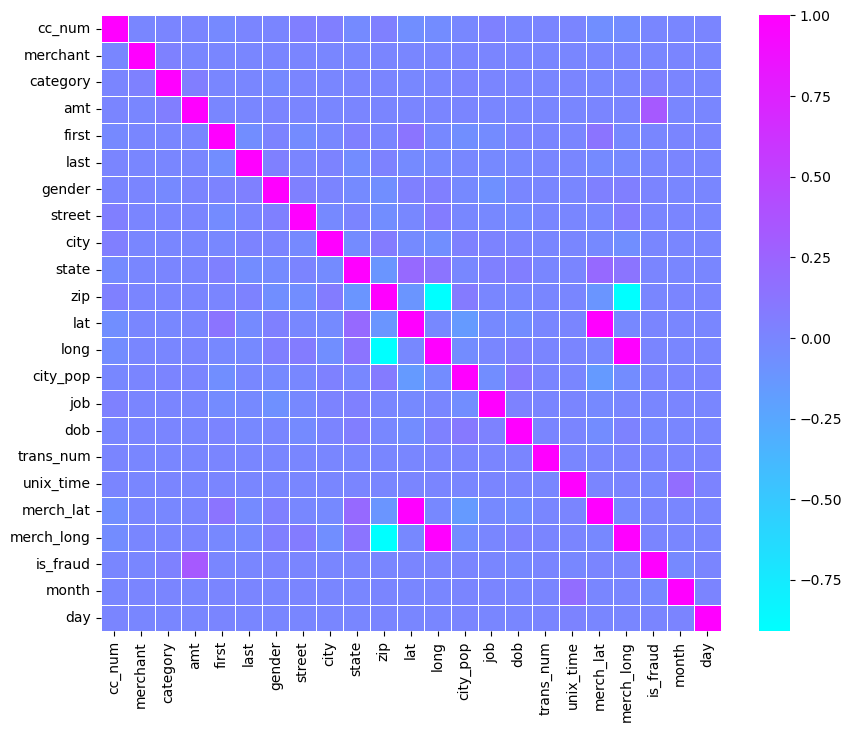

In [9]:
for column in df.columns:
    if df[column].dtype == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        df[column] = encoder.transform(df[column].astype(str))

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='cool', linewidth=0.5, annot=False)

<b>Now we can look at the distribution of the data and see if we have any obvious outliers we can remove. I'll demonstrate this with one feature and then apply it to the rest. Below we can see the relationship between amount and whether or not the transaction is fraudulent. The circles are outiers and we will look to remove the ones that are significantly outside the norm. These would appear off on their own and not be clustered near the box plots.</b>

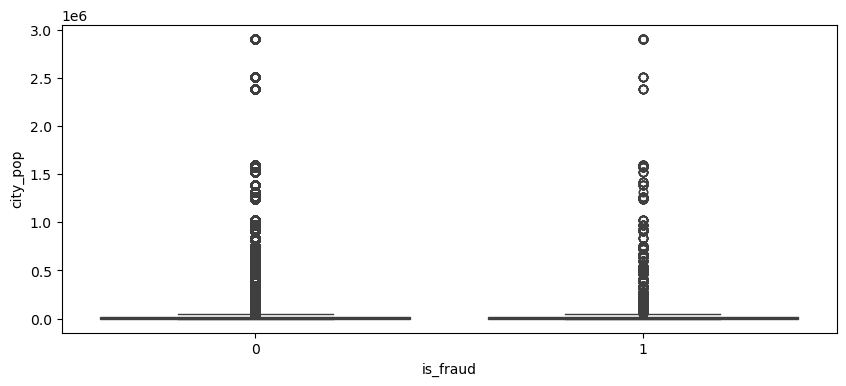

In [10]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10,4))

#Positive Correlations
sns.boxplot(x="is_fraud", y="city_pop", data=df,  ax=ax1)
plt.show()

[  247 26551  1666 ... 19408   129 14228]


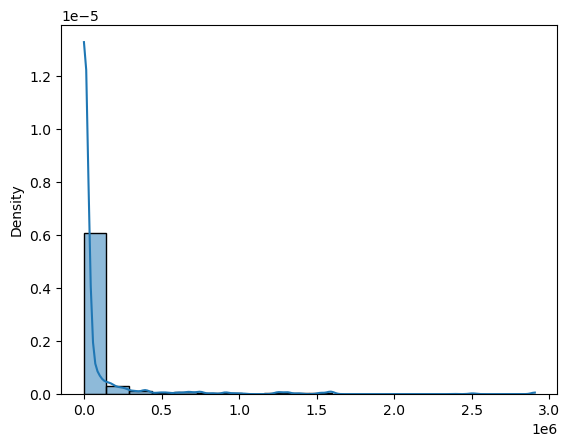

In [11]:
Amount_dist = df['city_pop'].values
sns.histplot(Amount_dist, kde=True, bins=20, stat='density')
print(Amount_dist)

<b>As we can see, there are a few significant outliers and the data itself is heavily skewed in one direction. To help aleviate this, we are going to calculate the range that falls within the boxes in the box plots above and then set a limit beyond that which we will beging removing values. in this case it will be 1.75 times the size of that range.</b>

In [12]:
def outlier_remover(feature, df):
    feature_out = df[feature].values
    q25, q75 = np.percentile(feature_out, 25), np.percentile(feature_out, 75)
    feature_range = q75 - q25

    feature_limit = feature_range * 1.75
    feature_low, feature_high = q25 - feature_limit, q75 + feature_limit

    outliers = [x for x in feature_out if x < feature_low or x > feature_high]

    df = df.drop(df[(df[feature] > feature_high) | (df[feature] < feature_low)].index)
    return df

df = outlier_remover('city_pop', df)

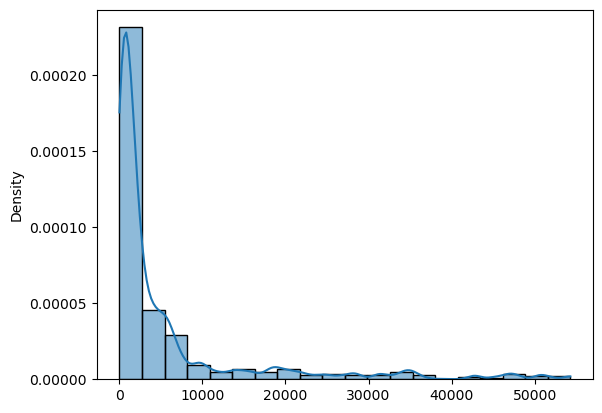

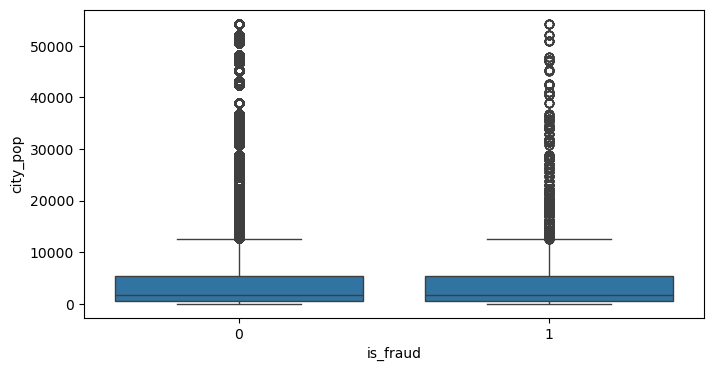

In [13]:
Amount_dist = df['city_pop'].values
sns.histplot(Amount_dist, kde=True, bins=20, stat='density')

fig, (ax1) = plt.subplots(ncols=1, figsize=(8,4))

#Positive Correlations
sns.boxplot(x="is_fraud", y="city_pop", data=df,  ax=ax1)
plt.show()

<b>We can see above that the graph for City Population values looks a little less skewed, although still far from normal. While not necessarily ideal, this has helped eliminate a lot of the outliers as we can see in the box plots. We'll continue this with the rest of our values we've been analyzing below and see how this effects the training of our model.</b>

In [14]:
print('data size before removal of remaining outliers: ' + str(df.size))

fraud = df.loc[df['is_fraud'] == 1] #has about 5700 fraud rows in it
non_fraud = df.loc[df['is_fraud'] == 0] #non_fraud at this point has no fraud values in it.
for x in (non_fraud.columns):
    if x == 'is_fraud' or x == 'city_pop':
        break
    else:
        non_fraud = outlier_remover(x, non_fraud)


final_df = pd.concat([fraud, non_fraud])
print(final_df['is_fraud'].value_counts())
final_df.sample(frac=1).reset_index(drop=True)
print('data size after removal of remaining outliers: ' + str(final_df.size))

data size before removal of remaining outliers: 7520632
is_fraud
0    280087
1      5918
Name: count, dtype: int64
data size after removal of remaining outliers: 6578115


In [15]:
df = final_df

df.info()

print(df['is_fraud'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 286005 entries, 401 to 121958
Data columns (total 23 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cc_num      286005 non-null  float64       
 1   merchant    286005 non-null  int32         
 2   category    286005 non-null  int32         
 3   amt         286005 non-null  float64       
 4   first       286005 non-null  int32         
 5   last        286005 non-null  int32         
 6   gender      286005 non-null  int32         
 7   street      286005 non-null  int32         
 8   city        286005 non-null  int32         
 9   state       286005 non-null  int32         
 10  zip         286005 non-null  int64         
 11  lat         286005 non-null  float64       
 12  long        286005 non-null  float64       
 13  city_pop    286005 non-null  int64         
 14  job         286005 non-null  int32         
 15  dob         286005 non-null  datetime64[ns]
 16  trans

<b>This leaves us with just over 280,000 transactions to work with and a skewed dataset. In this case, this will be acceptable to begin training with and we can make improvements as needed. Random Forests are very robust and good at modeling even with imperfections in our data sets ().</b>

# Step 3: Training the model -

<b> From here we can go ahead and make our training and testing datasets from what we processed above. The dataset will be split into training and testing sets before using the training set to train the model and the testing set to measure the capabilities of the training session.</b>

In [16]:
df = df.drop(columns=['dob', 'unix_time']) #dropping Dob information due to Dtype error. Could split into separate date/time information
                            #such as month, day, hour, etc. but not necessary in this case.

features_df = df.drop(columns=['is_fraud'])
target_df = df['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.1, random_state=42)

#print("Shape of X_train:", X_train.shape)
#print("Shape of X_test:", X_test.shape)
#print("Shape of y_train:", y_train.shape)
#print("Shape of y_test:", y_test.shape)

F1 score: 0.9147286821705426
Accuracy: 0.9969231845040383
Recall: 0.8443649373881932



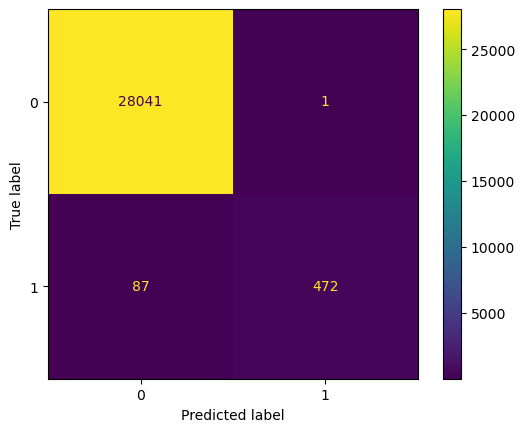

In [17]:
##This step is going to take a minute or two to complete.
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict(X_test)

print("F1 score: " + str(f1_score(y_test, y_predict)))
print("Accuracy: " + str(accuracy_score(y_test, y_predict)))
print("Recall: " + str(recall_score(y_test, y_predict)))
print()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predict))
disp.plot()
plt.show()

<b>We can see that this model (should) have around 99% accuracy, around 95 false negatives, and 0 or 1 false positives. I would call this sufficiently accurate given that my goal with this model is to ensure we have very few false negatives (cases of fraud going undetected) and minimal false positives which could lead to customer dissatisfaction. Considering a test size of 28,570 transactions (the sum of the confusion matrix values) 100 cases is 0.35%. This means that 0.35% of bank patrons experienced an undetected fraudulent transaction. This seems sufficiently accurate to try running this on simulated "real world" data below.</b>

### Visualizing the model -
<b>The below code shows our random forest as a whole, which is not necessairly very useful in its current form, but it is interesting to have a visual representation of the model and see the different trees and their shapes.</b>

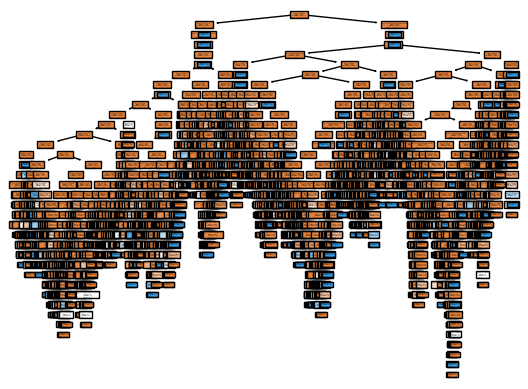

In [18]:
tree = random_forest.estimators_[0]
plot_tree(tree, filled=True)
plt.show()

<b>Something that we can look at is a truncated version of a random forest below that depicts what we would see if we could zoom in. This provides some insite into how the decision trees are formed. In order to do this, we have to re-run the training with a smaller depth so this is not exaclty what the tree above shows, but keeps with the same general idea.</b>

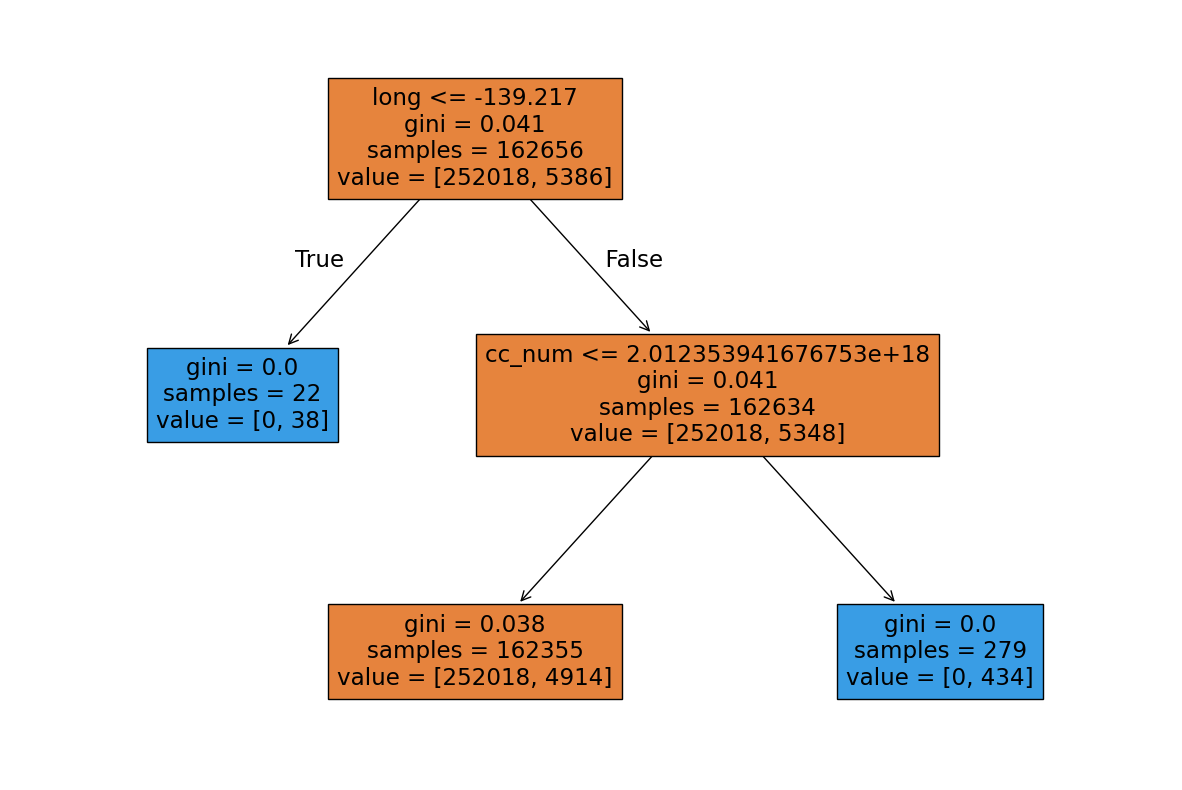

In [19]:
random_forest = RandomForestClassifier(max_depth = 2)

random_forest.fit(X_train, y_train)
y_predict = random_forest.predict(X_test)

tree = random_forest.estimators_[0]
plt.figure(figsize=(15, 10))
plot_tree(tree, feature_names = X_train.columns, filled=True)
plt.show()

## Step 4: The Tool (and additional UI)
<b>For all of this work to be useful, it needs to do something to solve our problem of detecting fraudulent transactions.First, is our tool that is what the bank would see as an end product where you can input a file and you would see a result with what transactions are being flagged as fraudulent. The second it just a "for fun" user interface where you can select from a few different values and see if the model will predict if it could be real or fraud.</b>

<b>For the tool below, the file name has been entered for you. This is where the employee checking transaction could type in the file name they wished to have scanned with the tool. The first few lines will be displayed to confirm that this is the file you want. Then click "Generate report" below. For the purposes of this project, accuracy and a confusion matrix are included to show how well the tool performed with new data. The deployed tool would not have access to whether the transaction was actually fraud or not at the time of the report to be able to produce these metrics.</b>

In [20]:
widgets.interact_manual.opts['manual_name'] = 'Submit'


def bank_tool(file_name):
    global bank_df
    bank_df = pd.read_csv(file_name, index_col=0).reset_index()
    return bank_df.head()

interact_manual(bank_tool, description='tool',
    file_name = 'bank_data.csv',
    );

interactive(children=(Text(value='bank_data.csv', continuous_update=False, description='file_name'), Button(de…

In [21]:
widgets.interact_manual.opts['manual_name'] = 'Generate Report'

def report():
    global bank_df
    global random_forest
    
    for column in bank_df.columns:
        if bank_df[column].dtype == 'object':
            encoder = LabelEncoder()
            encoder.fit(bank_df[column])
            bank_df[column] = encoder.transform(bank_df[column].astype(str))

    fraud_trans = bank_df['is_fraud']
    new_cols = ['dob', 'unix_time', 'is_fraud']
    bank_df = bank_df.drop(columns = new_cols)
    bank_df['trans_date_trans_time'] = pd.to_datetime(bank_df['trans_date_trans_time'])
    bank_df['month'] = bank_df['trans_date_trans_time'].dt.month
    bank_df['day'] = bank_df['trans_date_trans_time'].dt.day
    bank_df = bank_df.drop(columns = ['trans_date_trans_time'])
    y_predict = random_forest.predict(bank_df)
    bank_df['is_fraud'] = y_predict

    bank_df.reset_index(inplace=True)
    print("Suspected Fraudulent Transactions Report:")
    bank_df['trans_num'] = encoder.inverse_transform(bank_df['trans_num'])
    for x in range(len(bank_df)):
        if bank_df.loc[x, 'is_fraud'] == 1:
            print(bank_df.loc[x, 'trans_num'])

    print("Total Fraudulent flags: ")
    print(np.count_nonzero(y_predict == 1))
    print()
    print("Accuracy: " + str(accuracy_score(fraud_trans, y_predict)))
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(fraud_trans, y_predict))
    disp.plot()
    plt.show()

interact_manual(report, description='transaction report'
    );

interactive(children=(Button(description='Generate Report', style=ButtonStyle()), Output()), _dom_classes=('wi…

<b>For the "real world" data, there were a fair number of false positives meaning the tool flagged transactions that were not fraud. In this instance, as with many real world banks, this could be alleviated with a system that prompts the account holders to verify that the transaction is from them through a 2-step verification process like a text message alert. The main concern is false negatives, where the transaction is allowed to go through without anyone noticing it. In this case, the model missed about 150 out of 10,000 cases. This amounts to almost 98.5% accuracy with the metric that we are most concerned with, which is sufficient to be considered a success.</b>

### User Input:
<b>Use the drop down menus to select desired features and click on submit to see if the system flags it as fraud our not. The rest of the transaction data will be randomly generated and youu can see all the feature values that are being put in.</b>

In [22]:
widgets.interact_manual.opts['manual_name'] = 'Submit'


def my_function(Month, Day, Amount):
   
    input = df.iloc[2][1:-2]
    input.drop(columns = ['merch_lat', 'merch_long'])
    for x in range(len(input)):
        input[x] = rnd.random() * 1000
    input['month'] = Month
    input['day'] = float(Day)
    input['amt'] = float(Amount)
    sample = input.values.reshape(1,-1)
    print(sample)
    y_predict = random_forest.predict(sample)
    if y_predict == 1:
        print("Transaction Flagged as Fraud!")
    else:
        print("Not suspicious")

interact_manual(my_function, description='test',
    Month = [("January", 1), ("February", 2), ("March", 3), ("April", 4), ("May", 5), ("June", 6), ("July", 7), ("August", 8), ("September", 9), ("October", 10), ("November", 11), ("December", 12)],
    Day = '30', 
    Amount = 'Enter amount "xx.xx"'
    );


interactive(children=(Dropdown(description='Month', options=(('January', 1), ('February', 2), ('March', 3), ('…